In [1]:
#scanpy官方tutorial：https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html

import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

In [4]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))  #facecolor是背景颜色
sc.settings.verbosity = 3

In [5]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

100%|███████████████████████████████████████████████████████████████████████| 8.81M/8.81M [00:12<00:00, 725kB/s]
100%|██████████████████████████████████████████████████████████████████████| 19.6M/19.6M [00:17<00:00, 1.17MB/s]

reading /home/pengr/github/BDBA/PengRui/Projects/SpatailTutorial/data/V1_Mouse_Brain_Sagittal_Anterior/filtered_feature_bc_matrix.h5


 (0:00:00)


/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
100%|██████████████████████████████████████████████████████████████████████| 9.26M/9.26M [00:08<00:00, 1.19MB/s]
100%|██████████████████████████████████████████████████████████████████████| 20.1M/20.1M [00:17<00:00, 1.18MB/s]

reading /home/pengr/github/BDBA/PengRui/Projects/SpatailTutorial/data/V1_Mouse_Brain_Sagittal_Posterior/filtered_feature_bc_matrix.h5


 (0:00:00)


/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

/tmp/ipykernel_52283/1939748921.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_52283/1939748921.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_52283/1939748921.py:15: UserWarning: 

`distplot` is a deprecat

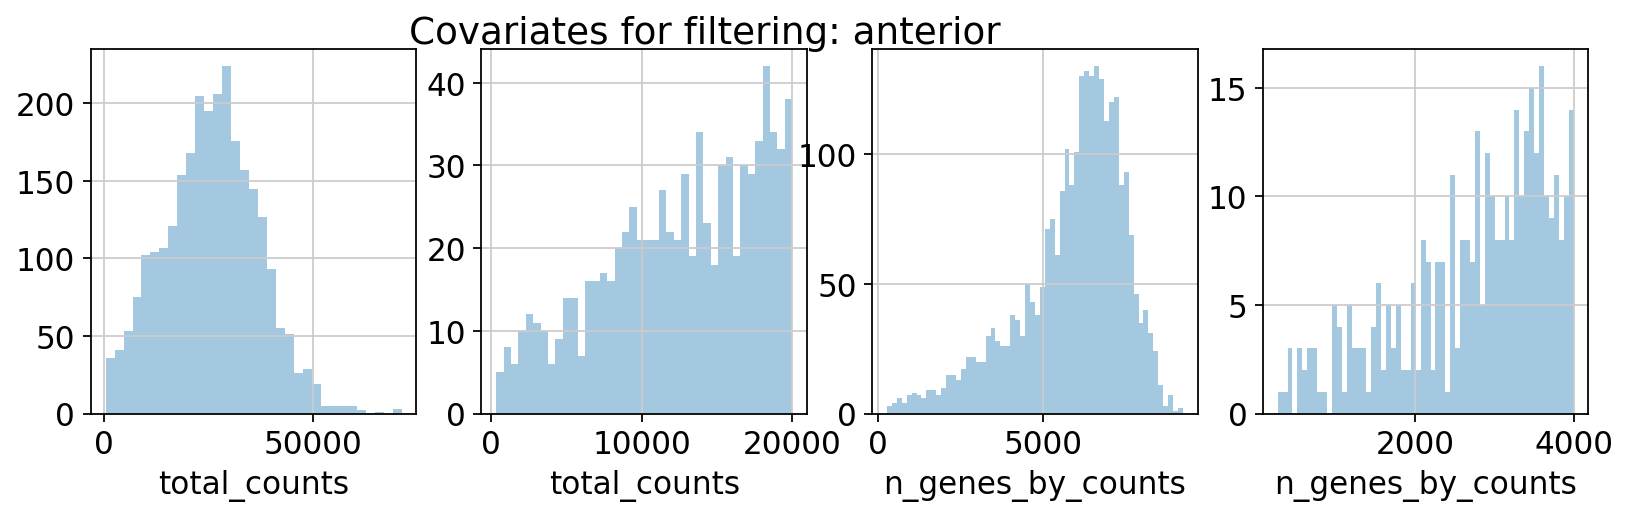

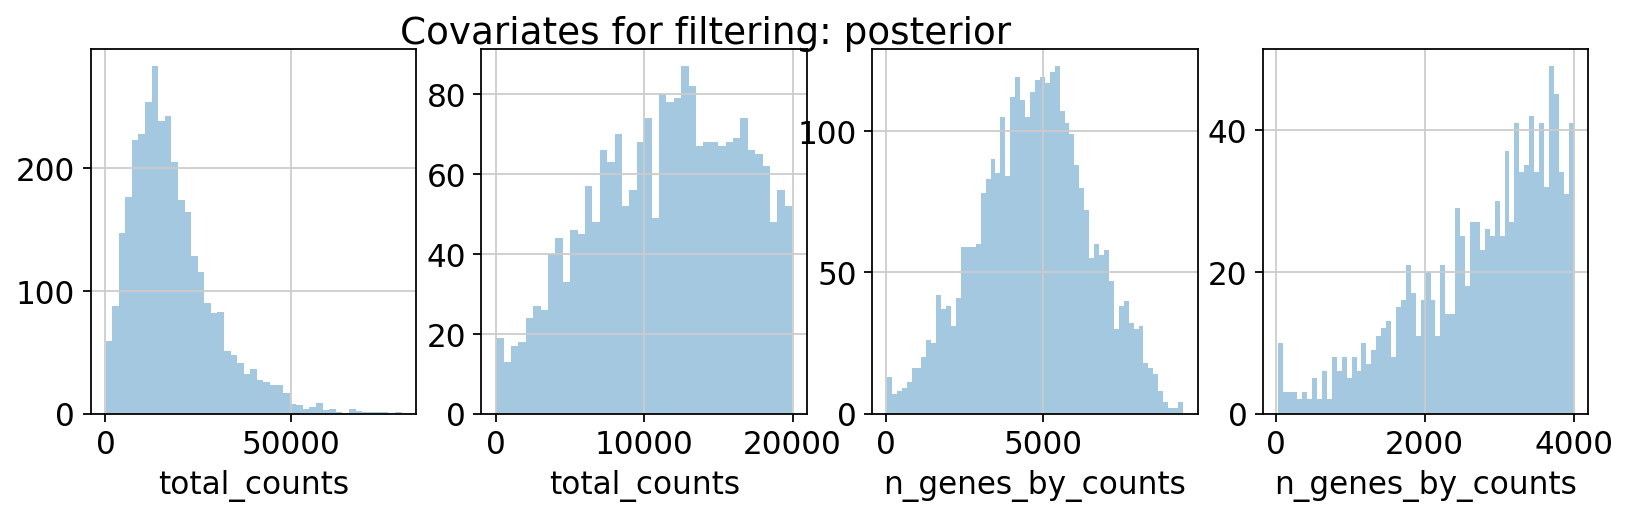

In [7]:
#观察数据分布

for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [8]:
#对数据做预处理，并选取

for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    """
    机器学习算法中，一些算法要求数据符合正态分布，但是对于一些标签和特征来说，分布不一定符合正态分布，
    用log1p(x)可以使得数据在一定程度上符合正态分布的特征。
     数据预处理时首先可以对偏度比较大的数据用og1p函数进行转化，使其更加服从高斯分布，此步处理可能会使我们后续的分类结果得到一个好的结果。
    """
    sc.pp.log1p(adata) 
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
#整合两个数据集，用scanorama来去除批次效应

adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.48941878]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/scanorama/scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


In [12]:
adata_spatial = sc.concat(
    adatas_cor,
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
    index_unique="-",
)

In [15]:
adatas_cor

[AnnData object with n_obs × n_vars = 2695 × 32285
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial', 'log1p', 'hvg'
     obsm: 'spatial', 'X_scanorama',
 AnnData object with n_obs × n_vars = 3355 × 32285
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_coun

In [13]:
adata_spatial

AnnData object with n_obs × n_vars = 6050 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'X_scanorama'

In [16]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

computing neighbors


/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-26 20:50:46.088003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 20:50:46.824777: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 22 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengr/mambaforge/envs/CCST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


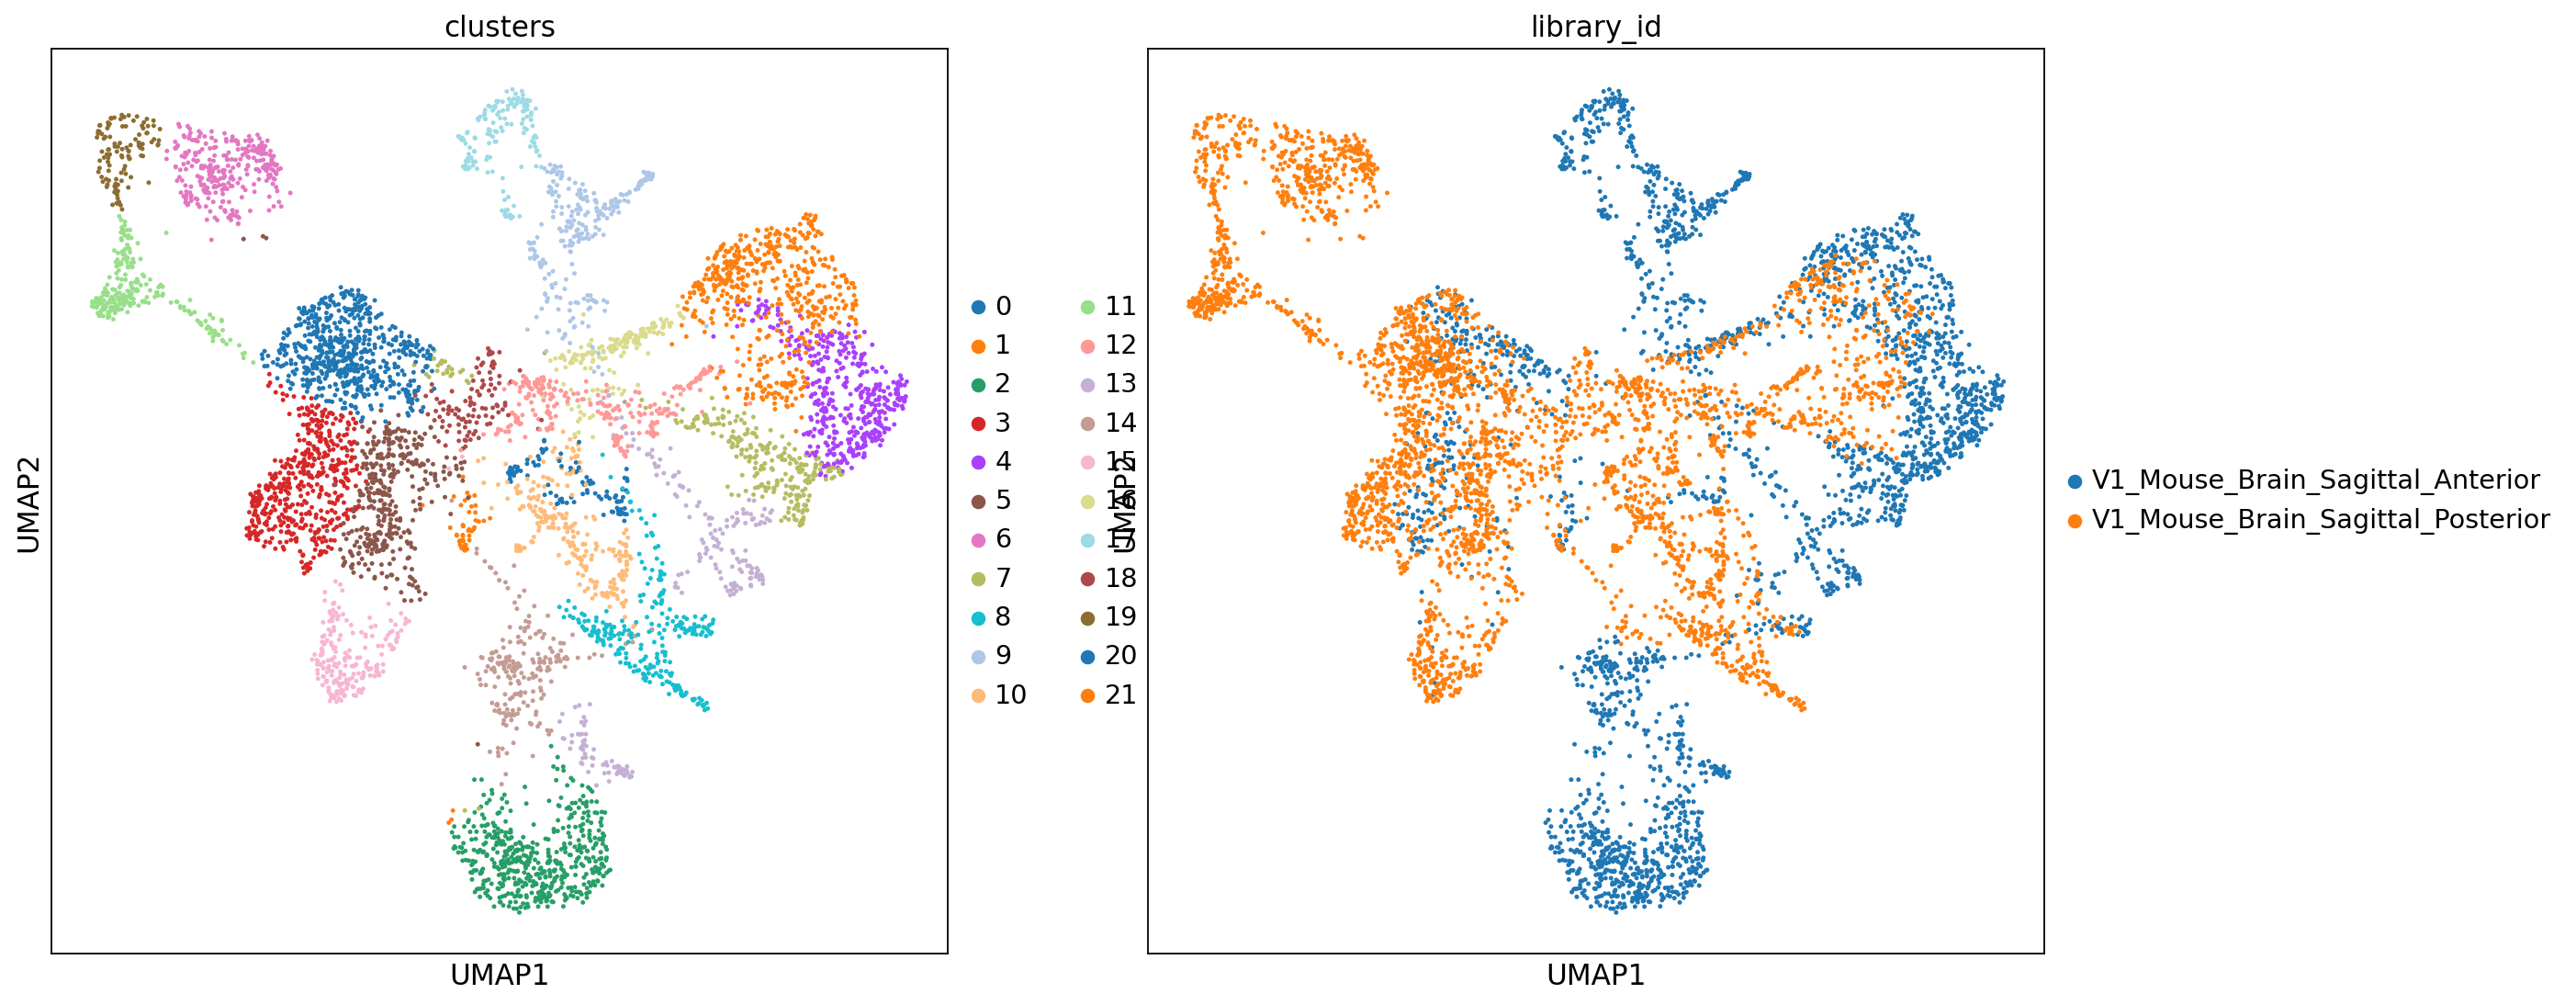

In [17]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

In [18]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

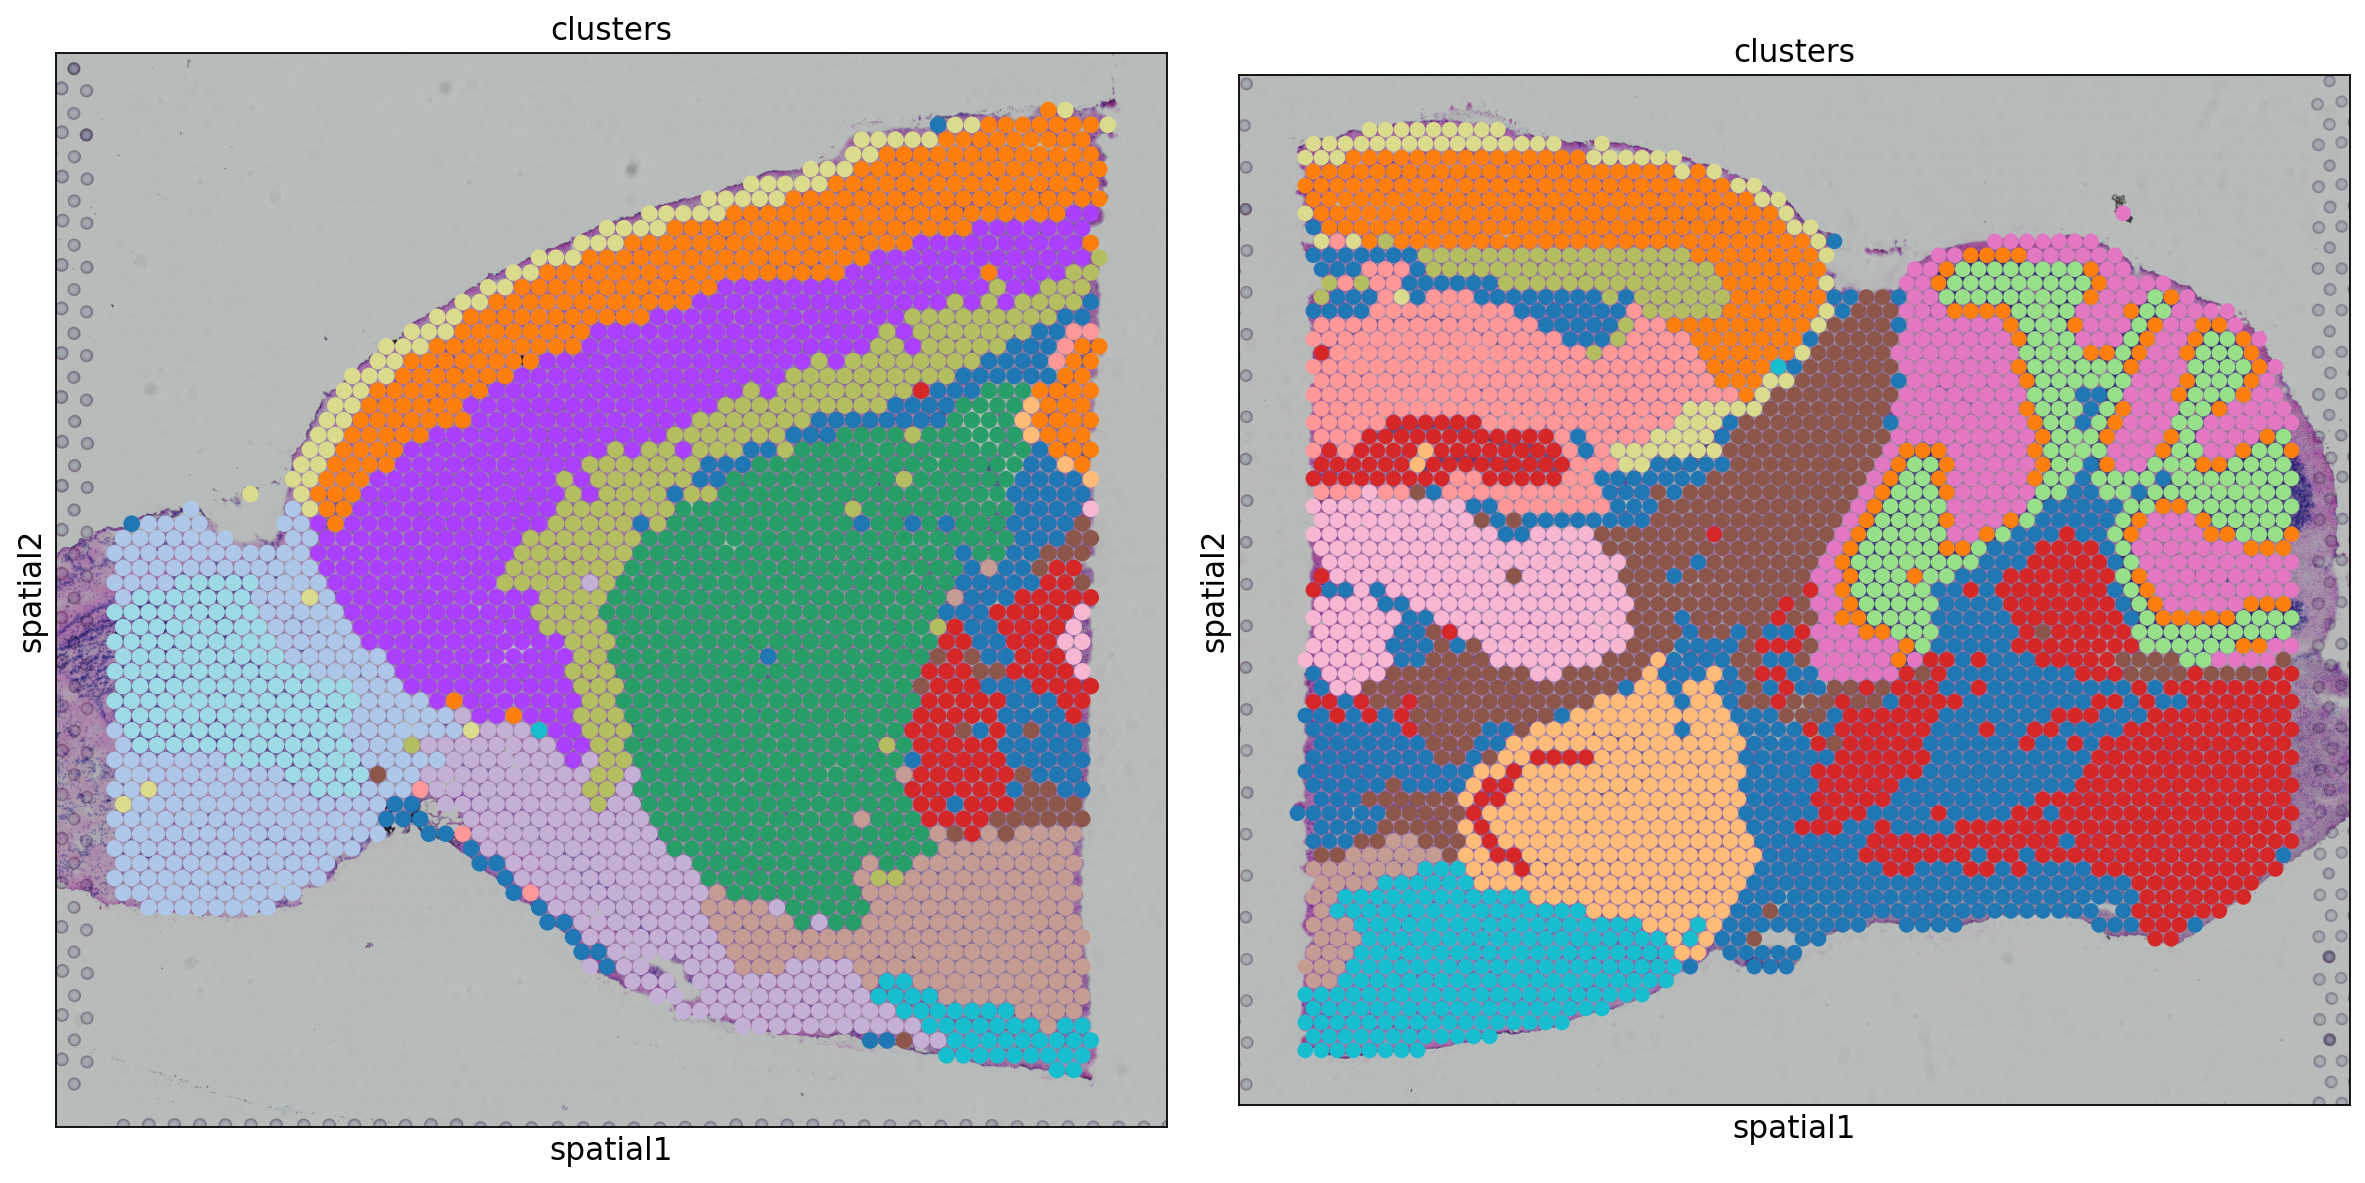

In [19]:
#在组织切片上成像

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()